In [1]:
# import libraries
import pandas as pd
import numpy as np

# our helper function
from helper import *

In [2]:
import numpy as np

def auto_detect_facies(density, acoustic, PE, normalized=False):
    
    # normalizer
    def normalizer(x, xmin, xmax, scale='cart'):
        # layer for logscale
        if scale == 'log':
            x, xmin, xmax = map(log10, [x, xmin, xmax])
        # normalization
        norm_val = (x - xmin) / (xmax - xmin)
        return norm_val
    
    if normalized:
        density = normalizer(density, 1.95, 2.95)
        acoustic = normalizer(acoustic, 40, 140)
        PE = normalizer(PE, 0, 10)
        coord1 = np.asarray([density, acoustic, PE])
        facies_dict = {
            'SS' : [normalizer(2.65, 1.95, 2.95), normalizer(53  , 40, 140), normalizer(1.81, 0, 10)],
            'LS' : [normalizer(2.71, 1.95, 2.95), normalizer(47.5, 40, 140), normalizer(5.08, 0, 10)],
        }
    else:
        coord1 = np.asarray([density, acoustic, PE])
        facies_dict = {
            'SS' : [2.65, 53  , 1.81],
            'LS' : [2.71, 47.5, 5.08],
        }
    
    # calculate distance
    dist = {}
    for key,val in facies_dict.items():
        coord2 = np.asarray(val)
        dist[key] = np.linalg.norm(coord1 - coord2)
        
    return min(dist, key=dist.get)

In [3]:
# change pandas display options
pd.options.display.max_columns = 100

In [11]:
# read data
data = pd.read_csv('../data/synth_inputs/cheal-a10.csv')

In [12]:
# apply shale cutoff
data['shale_cutoff'] = data.GR.map(lambda x: 'sand' if x<=90 else np.nan if np.isnan(x) else 'shale')

In [13]:
# apply lithology detection
litho = []
for row in data.index:
    if data.at[row, 'shale_cutoff'] == 'sand':
        density = data.at[row, 'DENS']
        acoustic = data.at[row, 'DTC']
        PE = data.at[row, 'PEF']
        litho.append(auto_detect_facies(density, acoustic, PE, normalized=True))
    elif data.at[row, 'shale_cutoff'] == 'shale':
        litho.append('shale')
    else:
        litho.append(np.nan)
    
data['litho'] = litho

In [14]:
# remove nan
data2 = data.dropna(subset=['litho'])

In [15]:
data2.litho.unique()

array(['shale', 'SS', 'LS'], dtype=object)

In [17]:
data2.to_csv('data_to_plot.csv', index=None)

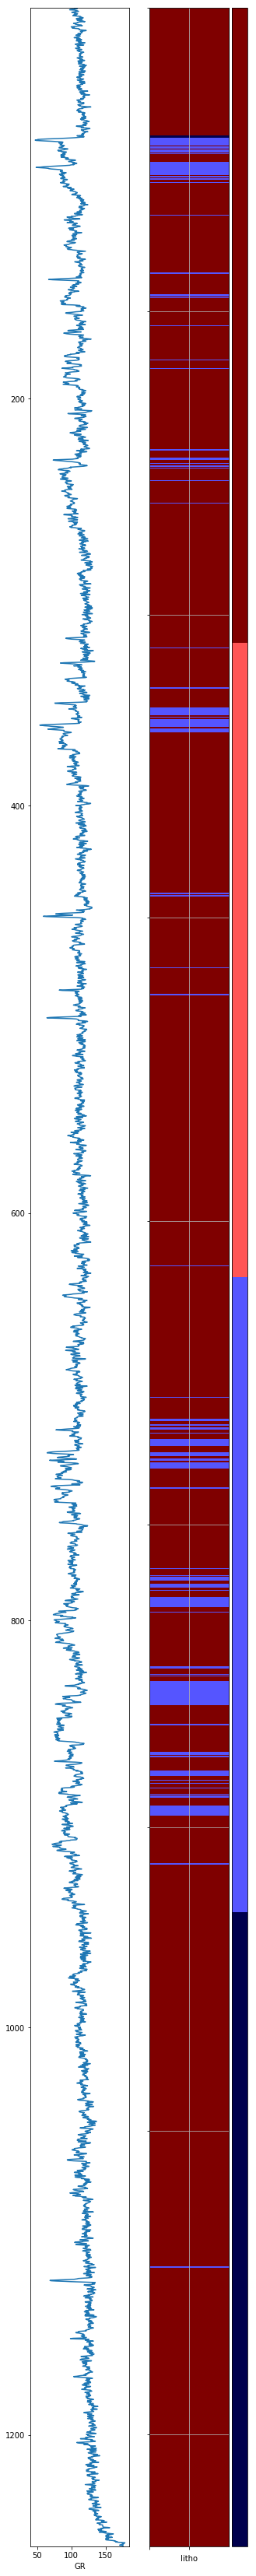

In [16]:
plotter(
    data=data2, depth_col=[0], num_col=[6], cat_col=[-1], cat_classes=[np.unique(litho).tolist()], figsize=(5, 60), base_cmap='seismic'
)